In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:15<00:00, 41.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [20]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Define target image size
target_size = (30, 30)

# Function to load and preprocess images
def load_and_preprocess_images(dataframe, dataset_path, target_size):
    images = []
    labels = []
    for index, row in dataframe.iterrows():
        img_path = os.path.join(dataset_path, row['Path'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, target_size) # Resize image
        images.append(img)
        labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

# Load and preprocess training data
print("Loading and preprocessing training images...")
train_images, train_labels = load_and_preprocess_images(train_df, dataset_path, target_size)
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)

# Load and preprocess test data
print("Loading and preprocessing test images...")
test_images, test_labels = load_and_preprocess_images(test_df, dataset_path, target_size)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to categorical
train_labels_categorical = to_categorical(train_labels, num_classes=len(class_counts))
test_labels_categorical = to_categorical(test_labels, num_classes=len(class_counts))

print("Training labels shape after categorical conversion:", train_labels_categorical.shape)
print("Testing labels shape after categorical conversion:", test_labels_categorical.shape)

Loading and preprocessing training images...
Training images shape: (39209, 30, 30, 3)
Training labels shape: (39209,)
Loading and preprocessing test images...
Testing images shape: (12630, 30, 30, 3)
Testing labels shape: (12630,)
Training labels shape after categorical conversion: (39209, 43)
Testing labels shape after categorical conversion: (12630, 43)


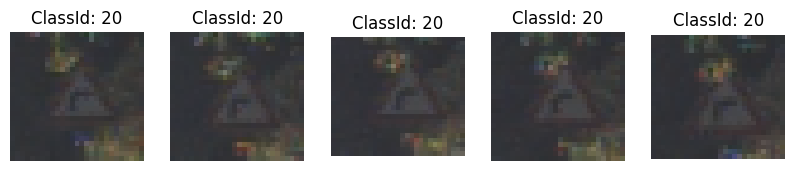

In [21]:
import matplotlib.pyplot as plt
import cv2
import os

# Assuming dataset_path and train_df are already defined

# Display a few training images
num_images_to_display = 5

plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    # Construct the full path to the image
    img_path = os.path.join(dataset_path, train_df['Path'][i])
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    # Convert the image from BGR to RGB for displaying with matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"ClassId: {train_df['ClassId'][i]}")
    plt.axis('off')

plt.show()

Class distribution in training data:
ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64


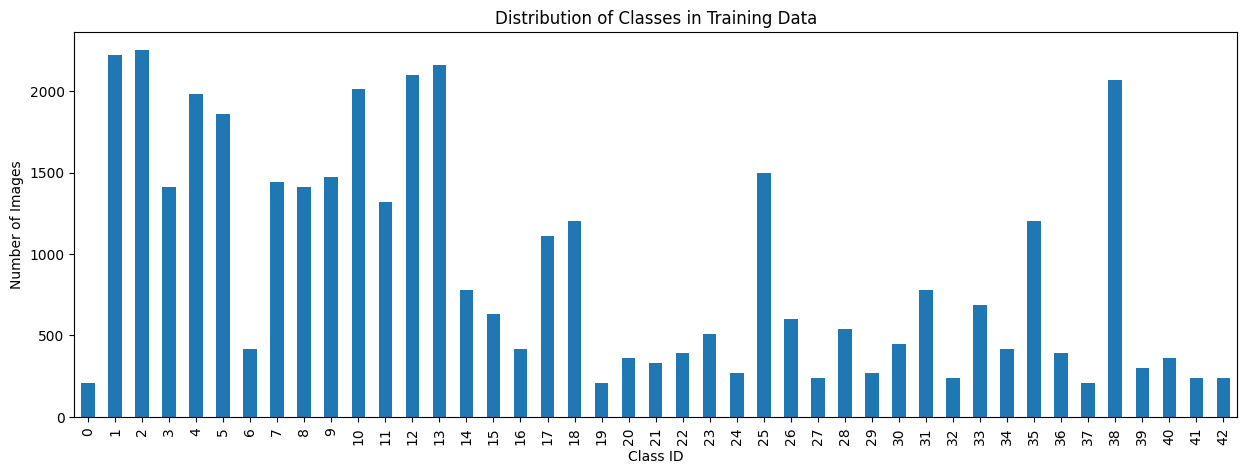

In [22]:
# Check class distribution in the training data
class_counts = train_df['ClassId'].value_counts().sort_index()

print("Class distribution in training data:")
print(class_counts)

# Optional: Visualize the class distribution
plt.figure(figsize=(15, 5))
class_counts.plot(kind='bar')
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.show()

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with the specified parameters
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

# Fit the data generator on the training data
datagen.fit(train_images)

print("Data augmentation applied to the training data.")

Data augmentation applied to the training data.


In [25]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_images, val_images, train_labels_categorical, val_labels_categorical = train_test_split(
    train_images, train_labels_categorical, test_size=0.2, random_state=42
)

print("Training images shape after split:", train_images.shape)
print("Validation images shape after split:", val_images.shape)
print("Training labels shape after split:", train_labels_categorical.shape)
print("Validation labels shape after split:", val_labels_categorical.shape)

Training images shape after split: (31367, 30, 30, 3)
Validation images shape after split: (7842, 30, 30, 3)
Training labels shape after split: (31367, 43)
Validation labels shape after split: (7842, 43)


In [27]:
from tensorflow.keras import models, layers

# Define image size and number of classes
IMG_SIZE = target_size[0]  # Use the previously defined target_size
NUM_CLASSES = len(class_counts) # Use the number of unique classes found earlier

def build_custom_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

custom_cnn = build_custom_cnn()
custom_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,499 (716.79 KB)

 Trainable params: 183,499 (716.79 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))

print("Class weights:")
print(class_weights_dict)

Class weights:
{0: np.float64(4.342081949058693), 1: np.float64(0.41073748166771423), 2: np.float64(0.4052609819121447), 3: np.float64(0.6466930562427841), 4: np.float64(0.46052384308198263), 5: np.float64(0.49023505876469115), 6: np.float64(2.1710409745293466), 7: np.float64(0.6332202842377261), 8: np.float64(0.6466930562427841), 9: np.float64(0.620297421294099), 10: np.float64(0.45365035288672917), 11: np.float64(0.6907857646229739), 12: np.float64(0.4342081949058693), 13: np.float64(0.4221468561584841), 14: np.float64(1.1690220632081096), 15: np.float64(1.447360649686231), 16: np.float64(2.1710409745293466), 17: np.float64(0.8214749633354285), 18: np.float64(0.7598643410852713), 19: np.float64(4.342081949058693), 20: np.float64(2.5328811369509046), 21: np.float64(2.7631430584918957), 22: np.float64(2.3380441264162193), 23: np.float64(1.7879160966712266), 24: np.float64(3.3771748492678726), 25: np.float64(0.6078914728682171), 26: np.float64(1.5197286821705427), 27: np.float64(3.79932

In [28]:
# Train the model with data augmentation and class weights
history = custom_cnn.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=128),
    epochs=50,  # You can adjust the number of epochs
    validation_data=(val_images, val_labels_categorical),
    class_weight=class_weights_dict
)

print("Model training complete.")

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


246/246 ━━━━━━━━━━━━━━━━━━━━ 32s 96ms/step - accuracy: 0.0370 - loss: 3.5600 - val_accuracy: 0.0807 - val_loss: 3.2290
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.0863 - loss: 2.9793 - val_accuracy: 0.2614 - val_loss: 2.2232
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.2692 - loss: 2.1867 - val_accuracy: 0.5038 - val_loss: 1.4564
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.4677 - loss: 1.5729 - val_accuracy: 0.6989 - val_loss: 0.8829
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.6177 - loss: 1.0502 - val_accuracy: 0.7980 - val_loss: 0.6182
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7216 - loss: 0.7233 - val_accuracy: 0.8752 - val_loss: 0.3790
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7713 - loss: 0.5408 - val_accuracy: 0.8852 - val_loss: 0.3407
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8207 - loss: 0.4192 - val_accurac

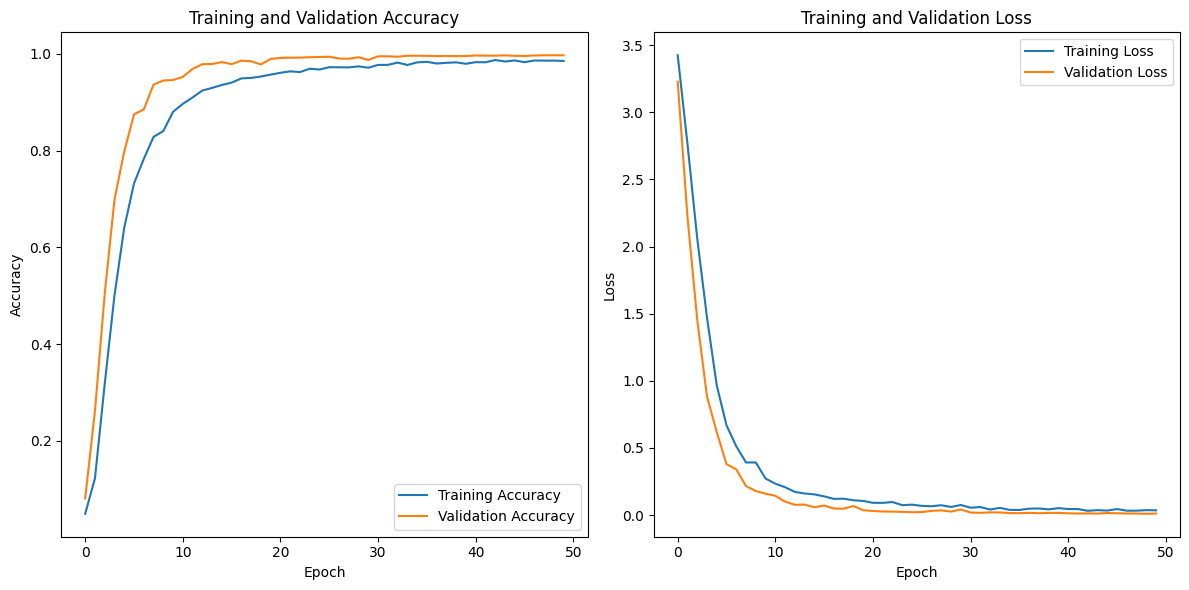

In [29]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


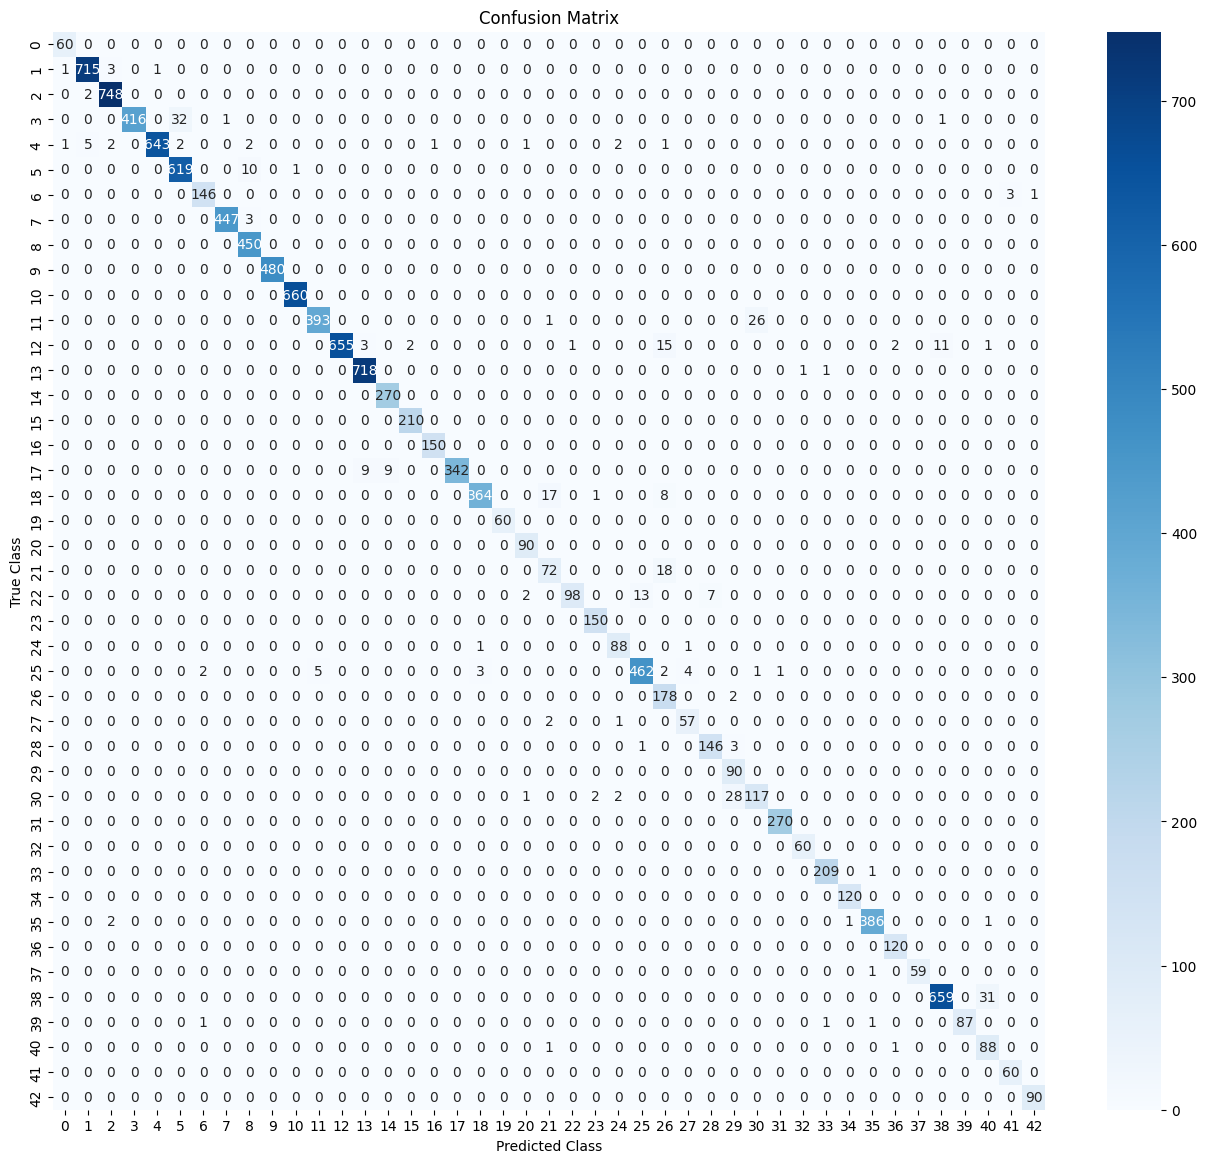

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the classes for the test images
y_pred = custom_cnn.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Evaluate the model on the test data
loss, accuracy = custom_cnn.evaluate(test_images, test_labels_categorical, verbose=0)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

Test Accuracy: 97.40%
Test Loss: 0.1391


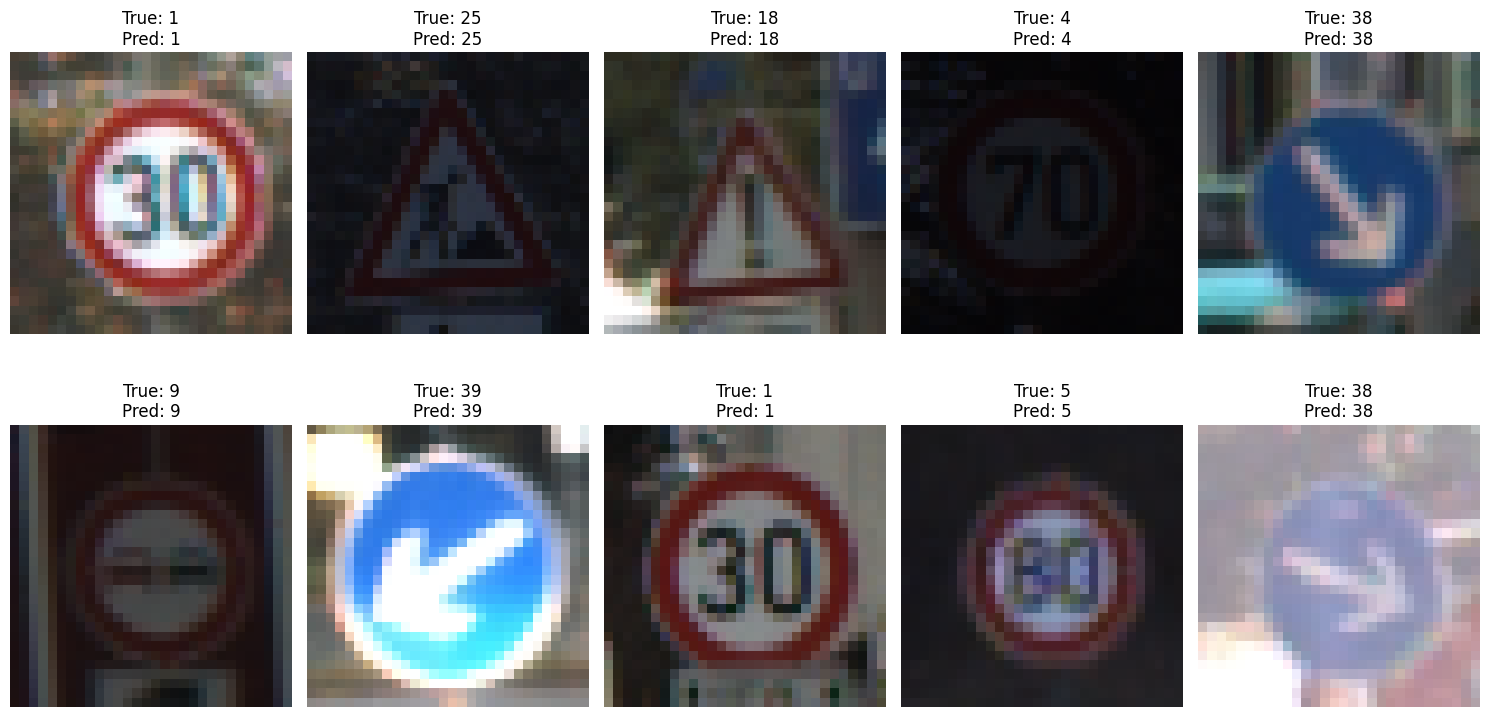

In [31]:
import random

# Display a few test images with true and predicted labels
num_images_to_display = 10

plt.figure(figsize=(15, 8))
for i in range(num_images_to_display):
    # Select a random image from the test set
    index = random.randint(0, len(test_images) - 1)
    img = test_images[index]
    true_label = y_true_classes[index]
    predicted_label = y_pred_classes[index]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2957460206.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 - 44s - 45ms/step - accuracy: 0.1950 - loss: 2.9023 - val_accuracy: 0.2669 - val_loss: 2.5514
Epoch 2/10
981/981 - 21s - 22ms/step - accuracy: 0.2532 - loss: 2.5678 - val_accuracy: 0.2979 - val_loss: 2.4087
Epoch 3/10
981/981 - 20s - 21ms/step - accuracy: 0.2698 - loss: 2.4759 - val_accuracy: 0.3143 - val_loss: 2.3469
Epoch 4/10
981/981 - 22s - 22ms/step - accuracy: 0.2810 - loss: 2.4310 - val_accuracy: 0.3199 - val_loss: 2.2994
Epoch 5/10
981/981 - 21s - 22ms/step - accuracy: 0.2879 - loss: 2.4021 - val_accuracy: 0.3295 - val_loss: 2.2653
Epoch 6/10
981/981 - 22s - 22ms/step - accuracy: 0.2957 - loss: 2.3715 - val_accuracy: 0.3335 - val_loss: 2.2527
Epoch 7/10
981/981 - 20s - 21ms/step - accuracy: 0.2968 - loss: 2.3618 - val_accuracy: 0.3364 - val_loss: 2.2235
Epoch 8/10
981/981 - 21s - 21ms/step - accuracy: 0.3027 - loss: 2.3382 - val_accuracy: 0.3415 - val_loss: 2.2062
Epoch 9/10
981/981 - 22s - 22ms/step - accuracy: 0.3028 - loss: 2.3327 - val_accuracy: 0.3420 - val_loss: 2

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


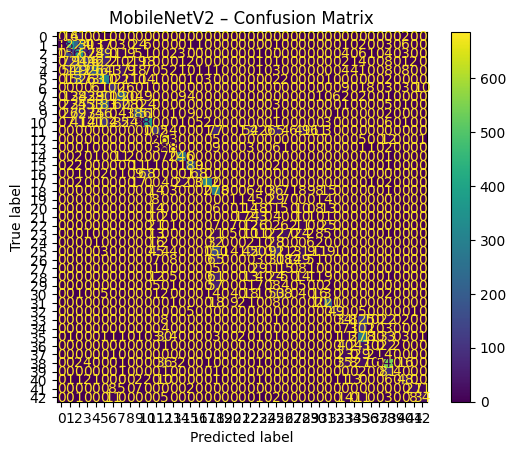

In [54]:
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Assuming IMG_SIZE and NUM_CLASSES are already defined

def build_mobilenet():
    base = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False  # freeze backbone first
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobile = build_mobilenet()
mobile.summary()

# Fast training on frozen backbone
# Using augmented data generator for training
history_frozen = mobile.fit(datagen.flow(train_images, train_labels_categorical, batch_size=32),
                            epochs=10,
                            validation_data=(val_images, val_labels_categorical),
                            callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
                            verbose=2)

# Optional fine-tuning: unfreeze last ~30 layers
base = mobile.layers[0]
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

mobile.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Fine-tuning
# Using augmented data generator for training
history_fine_tune = mobile.fit(datagen.flow(train_images, train_labels_categorical, batch_size=32),
                               epochs=10, # You can adjust the number of epochs
                               validation_data=(val_images, val_labels_categorical),
                               callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
                               verbose=2)

# Evaluation
test_pred_m = np.argmax(mobile.predict(test_images, verbose=0), axis=1)
test_true_m = test_labels

print("\nMobileNetV2 fine-tuned")
print(classification_report(test_true_m, test_pred_m))

cm2 = confusion_matrix(test_true_m, test_pred_m)
ConfusionMatrixDisplay(cm2).plot()
plt.title("MobileNetV2 – Confusion Matrix")
plt.show()